# Seminario: Laboratorio di Deep Learning

**Programmazione di Applicazioni Data Intensive**  
_(seminario non oggetto d'esame)_  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Deep Learning e Reti Neurali

- Il _deep learning_ si riferisce in generale a metodi di apprendimento basati su molteplici strati di rappresentazione dell'informazione
  - nel machine learning tradizionale è spesso richiesta una laboriosa ingegnerizzazione delle feature
  - l'obiettivo del deep learning è fornire al modello dati grezzi e far sì che le feature più appropriate siano apprese automaticamente
- Le _reti neurali_ sono il modello di deep learning più diffuso
  - sono composte da un numero di strati (_layer_) composti di nodi
  - ogni nodo riceve input da quelli dello strato sotto e trasmette l'output a quelli sopra
  - l'addestramento, basato su discesa gradiente, modifica progressivamente i pesi delle connessioni tra nodi in modo da ridurre l'errore nell'output della rete

## TensorFlow e Keras

- **TensorFlow** è un framework computazionale sviluppato da Google tra i più usati per il deep learning
  - TF permette di costruire un _grafo computazionale_, dove ogni nodo costituisce un'operazione tra _tensori_ (matrici n-dimensionali)
    - somme, prodotti, derivate, ...
  - i calcoli su uno stesso grafo possono essere svolti su CPU o (se disponibile) su GPU per maggiore efficienza
- **Keras** fornisce un'API di alto livello per costruire e addestrare reti neurali con TensorFlow
  - possiamo costruire una rete impilando strati di diverso tipo con molti (iper)parametri configurabili
  - possiamo addestrare ed utilizzare la rete con un'API simile a scikit-learn

## Setup

- Seguire le istruzioni che seguono per installare le librerie nei PC di laboratorio
  - queste istruzioni sono valide per qualsiasi PC con Anaconda installato
- Aprire un prompt dei comandi o terminale
  - in Windows: tasto Windows -> `cmd` -> Invio
- Creare un ambiente Anaconda con Python e installare le librerie richieste
  - `conda create -n deeplearn python=3.6 ipykernel numpy pandas matplotlib scikit-learn tensorflow keras`
- Attivare l'ambiente appena creato
  - Windows: `activate deeplearn`
  - Mac/Linux: `source activate deeplearn`
- Aggiungere l'ambiente come kernel in Jupyter
  - `python -m ipykernel install --user --name deeplearn --display-name "Deep learning"`

## Verifica

- Se questo le era già aperto in Jupyter, aggiornare la pagina
- Dal menù _Kernel_ selezionare _Change kernel_, quindi _Deep learning_
- Eseguire i seguenti import e verificare che non ci siano errori

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import keras

## Scaricamento Dati

- Definiamo la seguente funzione come supporto per scaricare i file di dati necessari

In [2]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Introduzione

- Per capire il funzionamento delle reti neurali, partiamo da un caso di regressione univariata
- Riprendiamo la predizione dei consumi elettrici in base alle temperature
- Carichiamo i dati...

In [3]:
download("power.csv", "https://git.io/vpaM1")
data = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])

In [4]:
data.head()

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


- Come abbiamo visto in precedenza, la relazione tra le due variabili non è lineare

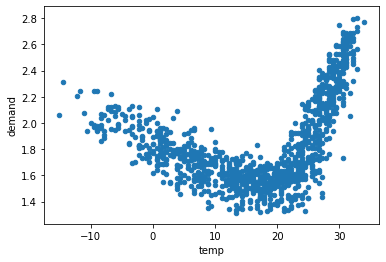

In [5]:
data.plot.scatter("temp", "demand")

- Come in precedenza, utilizziamo i dati di 2015 e 2016 come training set e i dati del 2017 come validation set

In [6]:
is_train = data.index.year < 2017
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

## Standardizzazione

- Nell'uso delle reti neurali è generalmente consigliato standardizzare i dati in ingresso
  - far sì che la media sia (circa) 0 e la deviazione standard (circa) 1
  - questo è importante in particolare per funzioni di attivazione non lineari (vedi dopo)
- Per eseguire la standardizzazione possiamo utilizzare il filtro `StandardScaler` di scikit-learn
- Creiamo un filtro per standardizzare i valori della temperatura

In [7]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()

- Tariamo ed applichiamo il filtro sui dati del training set...

In [8]:
X_train = scaler_X.fit_transform(X_train)

- ...per poi applicarlo a quelli del validation set

In [9]:
X_val = scaler_X.transform(X_val)

- Eseguiamo le stesse operazioni sulle y

In [10]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train[:, None]).ravel()
y_val = scaler_y.transform(y_val[:, None]).ravel()

## Creare una rete neurale in Keras

- Un modello _sequenziale_ di Keras è definito da una sequenza (senza diramazioni, cicli, ecc.) di strati connessi
  - ogni strato n propaga l'output allo strato n+1
  - il primo strato riceve l'input alla rete
  - l'ultimo strato fornisce l'output della rete
- Si definisce con un oggetto `Sequential` definendo la lista di strati
- Il tipo di strato più comune è `Dense`, in cui ogni nodo riceve input da tutti i nodi dello strato precedente

In [11]:
from keras.models import Sequential
from keras.layers import Dense

- Per iniziare, creiamo una "rete" con un singolo strato e un singolo nodo
- Su ogni strato `Dense` dobbiamo indicare il numero di nodi
- Inoltre sul primo strato dobbiamo indicare con `input_dim` il numero di valori in input, in questo caso uno

In [12]:
model = Sequential([
    Dense(1, input_dim=1)
])

Instructions for updating:
Colocations handled automatically by placer.


- L'output della rete sarà il valore restituito dal singolo nodo

- Una volta definita la struttura della rete questa va _compilata_ per costruirne il grafo computazionale su TensorFlow
- Quando si compila la rete va specificato un algoritmo di ottimizzazione (`optimizer`) da utilizzare per addestrare la rete
  - si possono usare diverse varianti della discesa gradiente stocastica
- Va inoltre specificata la misura di errore (`loss`) da minimizzare nell'addestramento
  - per la regressione usiamo l'errore quadratico medio

In [13]:
model.compile(optimizer="adam", loss="mean_squared_error")

- Ora possiamo addestrare la rete sul training set, usando il metodo `fit` come in scikit-learn
  - passiamo la matrice X con variabili indipendenti e il vettore y con variabile dipendente da predire
- Nella discesa gradiente stocastica gli esempi di training sono presi a gruppi di dimensione pari ad una `batch_size` indicata
- L'intero training set viene scorso in ordine casuale per un numero cicli di addestramento, detti _epoche_ (`epochs`)

In [14]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
731/731 [==============================] - 0s 519us/step - loss: 2.0938
Epoch 2/10
731/731 [==============================] - 0s 219us/step - loss: 1.7212
Epoch 3/10
731/731 [==============================] - 0s 228us/step - loss: 1.4335
Epoch 4/10
731/731 [==============================] - 0s 227us/step - loss: 1.2284
Epoch 5/10
731/731 [==============================] - 0s 227us/step - loss: 1.0871
Epoch 6/10
731/731 [==============================] - 0s 230us/step - loss: 0.9944
Epoch 7/10
731/731 [==============================] - 0s 225us/step - loss: 0.9360
Epoch 8/10
731/731 [==============================] - 0s 231us/step - loss: 0.9002
Epoch 9/10
731/731 [==============================] - 0s 226us/step - loss: 0.8796
Epoch 10/10
731/731 [==============================] - 0s 222us/step - loss: 0.8694


- Durante l'addestramento, l'errore sul training set, mostrato come `loss`, si riduce progressivamente
- L'andamento di epoca in epoca viene salvato nell'oggetto `fit_history`, possiamo visualizzarlo in un grafico

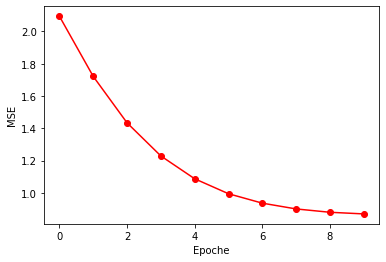

In [15]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

- Una volta addestrato, possiamo ottenere predizioni dal modello col metodo `predict` come in scikit-learn

In [16]:
model.predict(X_val[:3])

array([[-0.26690426],
       [-0.22499926],
       [-0.1961896 ]], dtype=float32)

- Si noti che i valori restituiti dal modello sono standardizzati sulla stessa scala usata nell'addestramento
- Possiamo usare il metodo `inverse_transform` del filtro per "destandardizzare" i valori alla scala originale

In [17]:
scaler_y.inverse_transform(model.predict(X_val[:3]))

array([[1.7705243],
       [1.7849156],
       [1.7948096]], dtype=float32)

- Il metodo `evaluate` esegue una valutazione su un validation set e restituisce la misura d'errore usata in addestramento (il MSE)

In [18]:
model.evaluate(X_val, y_val)

365/365 [==============================] - 0s 92us/step


0.6906151808287999

- Creiamo una funzione per visualizzare il modello sovrapposto al grafico a dispersione dei dati

In [19]:
def plot_regr_model(X, y, model):
    plt.scatter(X[:, 0], y)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    mx = np.linspace(xlim[0], xlim[1], 100)
    my = model.predict(mx)
    plt.plot(mx, my, c="red", lw=3)
    plt.xlim(xlim)
    plt.ylim(ylim)

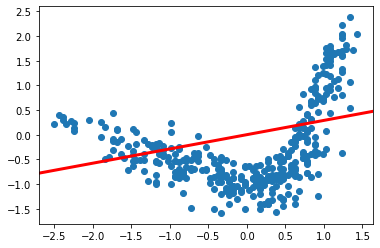

In [20]:
plot_regr_model(X_val, y_val, model)

- Questa corrisponde in pratica ad un modello di regressione lineare
  - l'output del singolo nodo è $y=w\cdot x+b$, dove $w$ è il peso dato all'input (il coefficiente) e $b$ è il _bias_ (l'intercetta)
- Non è in grado quindi di modellare dati con andamento non lineare

## Aggiungere uno strato

- Cosa succede aggiungendo uno strato al modello?
- Creiamo una rete con uno strato _nascosto_ ad es. di 16 nodi a cui viene passato l'input
- Definiamo una notazione con cui descrivere l'output della rete
  - con $w^l_{ij}$ definiamo il peso della connessione dal nodo $i$ dello strato $l-1$ al nodo $j$ dello strato $l$
  - con $b^l_j$ definiamo il bias applicato sul nodo $j$ dello strato $l$
- Ogni nodo dello strato nascosto $i$ fornirà come output:
$$ h_i = b^1_i + w^1_{1i}\cdot x $$
- A sua volta l'output sarà una combinazione di questi 16 nodi:
$$ y = b^2_1 + \sum_{i=1}^{16}{w^2_{i1}\cdot h_i} = b^2_1 + \sum_{i=1}^{16}{w^2_{i1}\cdot\left(b^1_i + w^1_{1i}\cdot x\right)} $$

In [22]:
model = Sequential([
    Dense(16, input_dim=1),
    Dense(1)
])

- Col metodo `summary` possiamo ottenere un resoconto della struttura della rete, in cui è evidenziato il numero di parametri addestrabili nella rete

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


- In questo caso ad esempio come parametri abbiamo
  - i 16 pesi dall'input ai nodi nascosti $w^1_{1i}$
  - i 16 bias dei nodi nascosti $b^1_i$
  - i 16 pesi dai nodi nascosti all'output $w^2_{i1}$
  - il bias dell'output $b^2_1$
- ...per un totale di 49 parametri da addestrare

- Come sopra compiliamo ed addestriamo la rete

In [20]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=10)

Epoch 1/10
731/731 [==============================] - 0s 643us/step - loss: 1.5266
Epoch 2/10
731/731 [==============================] - 0s 243us/step - loss: 0.1167
Epoch 3/10
731/731 [==============================] - 0s 233us/step - loss: 0.1021
Epoch 4/10
731/731 [==============================] - 0s 237us/step - loss: 0.1021
Epoch 5/10
731/731 [==============================] - 0s 236us/step - loss: 0.1036
Epoch 6/10
731/731 [==============================] - 0s 240us/step - loss: 0.1031
Epoch 7/10
731/731 [==============================] - 0s 236us/step - loss: 0.1033
Epoch 8/10
731/731 [==============================] - 0s 240us/step - loss: 0.1028
Epoch 9/10
731/731 [==============================] - 0s 235us/step - loss: 0.1036
Epoch 10/10
731/731 [==============================] - 0s 235us/step - loss: 0.1031


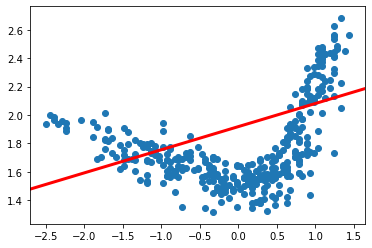

In [22]:
plot_regr_model(X_val, y_val, model)

- Otteniamo ancora un modello lineare, in quanto l'output finale rimane comunque una combinazione lineare delle variabili di input (in questo caso una sola)
$$ y = (\ldots)\cdot x + (\ldots) $$
- È quindi necessario introdurre operazioni non lineari

## Funzioni di attivazione

- Una funzione di attivazione non lineare può essere applicata a ciascun valore in output di un qualsiasi strato
  - tutte le funzioni di attivazione devono essere continue e differenziabili per poter eseguire la discesa gradiente
- Per impostare una funzione di attivazione usiamo il parametro `activation`
- Un esempio di funzione di attivazione comune è quella sigmoidale
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

![Sigmoid function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/500px-Logistic-curve.svg.png)

- Modifichiamo ad esempio la rete sopra in modo che abbia solo due nodi nascosti, ma che utilizzino la funzione di attivazione sigmoidale

In [24]:
model = Sequential([
    Dense(2, activation="sigmoid", input_dim=1),
    Dense(1)
])

- In questo modo l'output dei nodi nascosti sarà l'applicazione della funzione sigmoide
$$ h_i = \sigma\left(b^1_i + w^1_{1i}\cdot x\right) $$
- Il modello sarà in pratica una somma pesata di due sigmoidi

In [25]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [26]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=10)

Epoch 1/10
731/731 [==============================] - 1s 689us/step - loss: 1.3926
Epoch 2/10
731/731 [==============================] - 0s 249us/step - loss: 1.0347
Epoch 3/10
731/731 [==============================] - 0s 247us/step - loss: 0.9159
Epoch 4/10
731/731 [==============================] - 0s 250us/step - loss: 0.8769
Epoch 5/10
731/731 [==============================] - 0s 238us/step - loss: 0.8595
Epoch 6/10
731/731 [==============================] - 0s 252us/step - loss: 0.8478
Epoch 7/10
731/731 [==============================] - 0s 253us/step - loss: 0.8361
Epoch 8/10
731/731 [==============================] - 0s 257us/step - loss: 0.8238
Epoch 9/10
731/731 [==============================] - 0s 261us/step - loss: 0.8109
Epoch 10/10
731/731 [==============================] - 0s 268us/step - loss: 0.7977


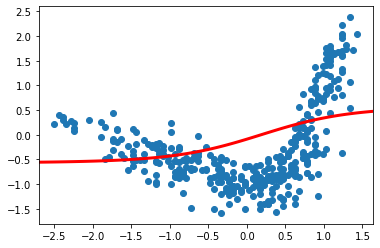

In [27]:
plot_regr_model(X_val, y_val, model)

- Introducendo nodi non lineari, la rete può potenzialmente modellare meglio la distribuzione dei dati

- Testiamo ora _ReLU_ (_Rectified Linear Unit_), un'altra funzione di attivazione comune
$$ R(z) = \left\{\begin{array}{ll} 0 & \text{if} z\leq 0 \\ z & \text{if} z>0 \end{array}\right. $$

![ReLU function](https://i.imgur.com/gKA4kA9.jpg)

In [28]:
model = Sequential([
    Dense(2, activation="relu", input_dim=1),
    Dense(1)
])

In [29]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [30]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=10)

Epoch 1/10
731/731 [==============================] - 1s 981us/step - loss: 1.0891
Epoch 2/10
731/731 [==============================] - 0s 469us/step - loss: 1.0090
Epoch 3/10
731/731 [==============================] - 0s 481us/step - loss: 0.9990
Epoch 4/10
731/731 [==============================] - 0s 400us/step - loss: 0.9959
Epoch 5/10
731/731 [==============================] - 0s 498us/step - loss: 0.9938
Epoch 6/10
731/731 [==============================] - 0s 476us/step - loss: 0.9925
Epoch 7/10
731/731 [==============================] - 0s 514us/step - loss: 0.9912
Epoch 8/10
731/731 [==============================] - 0s 414us/step - loss: 0.9899
Epoch 9/10
731/731 [==============================] - 0s 460us/step - loss: 0.9889
Epoch 10/10
731/731 [==============================] - 0s 544us/step - loss: 0.9875


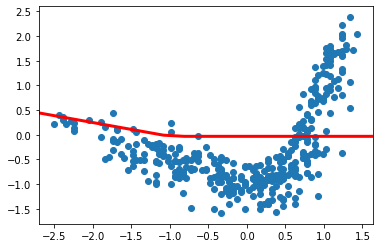

In [31]:
plot_regr_model(X_val, y_val, model)

- Aumentando i nodi nascosti, diventa possibile modellare relazioni più complesse e può aumentare l'aderenza del modello ai dati

In [32]:
model = Sequential([
    Dense(8, activation="relu", input_dim=1),
    Dense(1)
])

In [33]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [34]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=10)

Epoch 1/10
731/731 [==============================] - 1s 973us/step - loss: 1.0100
Epoch 2/10
731/731 [==============================] - 0s 536us/step - loss: 0.8400
Epoch 3/10
731/731 [==============================] - 0s 427us/step - loss: 0.6800
Epoch 4/10
731/731 [==============================] - 0s 493us/step - loss: 0.5282
Epoch 5/10
731/731 [==============================] - 0s 490us/step - loss: 0.4107
Epoch 6/10
731/731 [==============================] - 0s 446us/step - loss: 0.3405
Epoch 7/10
731/731 [==============================] - 0s 534us/step - loss: 0.3003
Epoch 8/10
731/731 [==============================] - 0s 470us/step - loss: 0.2739
Epoch 9/10
731/731 [==============================] - 0s 527us/step - loss: 0.2544
Epoch 10/10
731/731 [==============================] - 0s 528us/step - loss: 0.2392


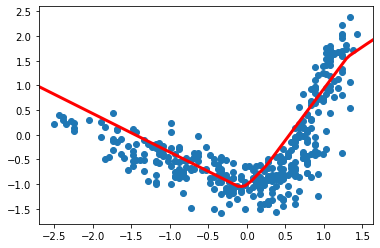

In [35]:
plot_regr_model(X_val, y_val, model)

## Classificazione non lineare

- Le reti neurali sono molto usate per classificare dati in due o più classi
- Come per la regressione lineare, l'uso delle reti neurali permette di individuare classi non linearmente separabili
- Vediamo un esempio di funzionamento con un dataset sintetico generato casualmente
- La funzione `make_circles` genera punti distribuiti in due corone circolari concentriche
- Generiamo due dataset da una stessa distribuzione, uno per training e l'altro per validazione

In [36]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5)
X_val, y_val = make_circles(1000, noise=0.1, factor=0.5)

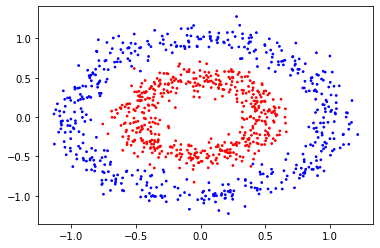

In [37]:
plt.scatter(X_train[:, 0], X_train[:, 1], s=3, c=np.where(y_train, "red", "blue"))

- Vogliamo addestrare un classificatore a distinguere, date le coordinate di un punto, se faccia parte della corona esterna o di quella interna

- Prendiamo ad esempio un semplice modello di regressione logistica

In [38]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train);

/home/pasolini/software/miniconda3/envs/deeplearn/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- Utilizziamo il classificatore addestrato per etichettare il validation set

In [39]:
yp_val = model.predict(X_val)

- Visualizziamo quindi il grafico di prima con colori in base alle risposte del classificatore

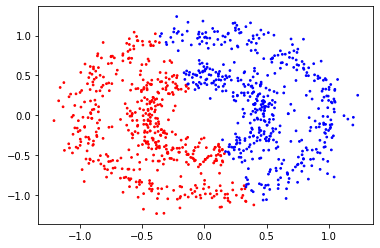

In [40]:
plt.scatter(X_val[:, 0], X_val[:, 1], s=3, c=np.where(yp_val, "red", "blue"))

- Essendo un classificatore lineare, non è in grado di separare correttamente le due classi

- Per maggiore dettaglio, creiamo una funzione per visualizzare le regioni di spazio in cui il classificatore suddivide i dati

In [47]:
def plot_class_model(X, y, predict):
    plt.scatter(X[:, 0], X[:, 1])
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    mx = np.linspace(xlim[0], xlim[1], 101)
    my = np.linspace(ylim[0], ylim[1], 101)
    mx, my = np.meshgrid(mx, my)
    mz = predict(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    plt.contourf(mx, my, mz, cmap="cool")
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y, "#880000", "blue"), s=4)

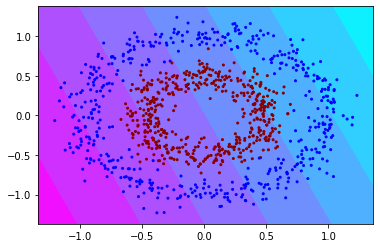

In [48]:
plot_class_model(X_val, y_val, model.predict_proba)

- Le sfumature sullo sfondo indicano le probabilità con cui il classificatore assegna un punto ad una classe o all'altra

- Conoscendo la forma del dataset, possiamo introdurre nuove variabili specifiche tali per cui le classi diventino linearmente separabili
- Introduciamo ad esempio variabili polinomiali di secondo grado

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr",   LogisticRegression())
])
model.fit(X_train, y_train);

/home/pasolini/software/miniconda3/envs/deeplearn/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
model.score(X_val, y_val)

0.986

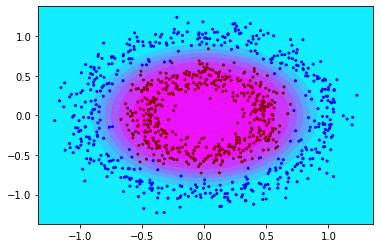

In [51]:
plot_class_model(X_val, y_val, model.predict_proba)

- Grazie all'uso dei quadrati delle variabili come feature, è possibile separare linearmente le due classi

- A conferma, si vedano i coefficienti del modello di regressione: i due con valori più significativi sono quelli dei quadrati (`x0^2` e `x1^2`)

In [52]:
pd.Series(
          model.named_steps["lr"].coef_[0],
    index=model.named_steps["poly"].get_feature_names()
)

x0      -0.052190
x1      -0.031052
x0^2    -7.864395
x0 x1    0.098679
x1^2    -8.060524
dtype: float64

- Si veda inoltre il grafico dei dati basato sulle due variabili quadratiche invece che su quelle originali

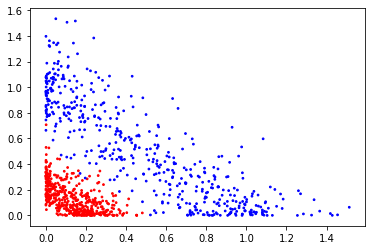

In [53]:
plt.scatter(X_val[:, 0]**2, X_val[:, 1]**2, s=3, c=np.where(y_val, "red", "blue"))

- Con questa rappresentazione le due classi sono linearmente separabili
- Tale rappresentazione è però stata decisa arbitrariamente da noi
- Una rete neurale è in grado di classificare correttamente i dati senza definire manualmente le nuove variabili?

## Classificazione con reti neurali

- Per suddividere oggetti in N classi, creiamo una rete neurale con un nodo di output per ciascuna classe
- Addestriamo quindi la rete in modo che il nodo di output corrispondente alla classe giusta dia un valore maggiore degli altri
- Per questo l'output atteso della rete, per ora rappresentato come un valore 0 o 1...

In [54]:
y_train[:5]

array([1, 0, 1, 0, 1])

- ...va rappresentato come un vettore _one-hot_ di due elementi, dove
  - 0 (punti esterni) si codifica con `[1, 0]`
  - 1 (punti interni) si codifica con `[0, 1]`
- Questa rappresentazione è utilizzabile con qualsiasi numero di classi
  - ad es. la quarta di 5 classi sarebbe codificata con `[0, 0, 0, 1, 0]`

- Keras fornisce un'apposita funzione `to_categorical` per codificare l'output in questo modo

In [55]:
from keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_val = to_categorical(y_val)

- Otteniamo così le coppie di valori corrispondenti ai valori attesi dei due nodi di output della rete in ciascun caso

In [56]:
yt_train[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

- Iniziamo addestrando un modello con uno strato nascosto di 8 nodi lineari
- Nello strato di output utilizziamo due nodi, uno per classe
- La funzione di attivazione `softmax` fa in modo che l'output della rete costituisca una distribuzione di probabilità tra le due classi, ovvero che la somma dei due valori sia sempre 1

In [69]:
model = Sequential([
    Dense(8, input_dim=2),
    Dense(2, activation="softmax")
])

- Per la classificazione, impostiamo `categorical_crossentropy` come misura dell'errore
  - l'errore è tanto più alto quanto più la probabilità stimata per la classe corretta si allontana da 100\%
- In aggiunta alla misura dell'errore da ottimizzare, possiamo aggiungere altre metriche di valutazione (`metrics`)
  - calcoliamo l'`accuracy`, ovvero la percentuale di esempi classificati correttamente

In [70]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [71]:
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=5)

Epoch 1/5
1000/1000 [==============================] - 1s 665us/step - loss: 0.7304 - acc: 0.4920
Epoch 2/5
1000/1000 [==============================] - 0s 219us/step - loss: 0.6993 - acc: 0.5140
Epoch 3/5
1000/1000 [==============================] - 0s 169us/step - loss: 0.6949 - acc: 0.4830
Epoch 4/5
1000/1000 [==============================] - 0s 186us/step - loss: 0.6941 - acc: 0.4170
Epoch 5/5
1000/1000 [==============================] - 0s 179us/step - loss: 0.6940 - acc: 0.4580


- In `fit_history` troviamo salvato l'andamento sia dell'errore che dell'accuratezza sul training set

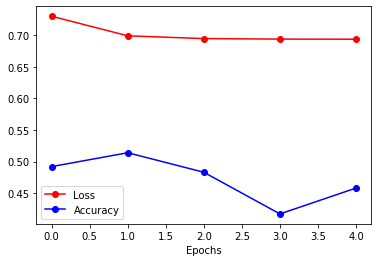

In [72]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["acc"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epochs");

- Dal grafico si nota già che l'accuratezza misurata sul training set non riesce ad aumentare

- Con `predict` otteniamo l'output "grezzo" della rete a fronte di input dati, ovvero le probabilità delle due classi

In [60]:
model.predict(X_val[:5])

array([[0.49531594, 0.50468403],
       [0.5047541 , 0.49524584],
       [0.51403826, 0.4859617 ],
       [0.50529   , 0.49471   ],
       [0.5093866 , 0.4906134 ]], dtype=float32)

- Per ottenere direttamente le classi predette (le più probabili), possiamo usare il metodo `predict_classes`

In [61]:
model.predict_classes(X_val[:5])

array([1, 0, 0, 0, 0])

- Con `evaluate` calcoliamo tutte le misure indicate in `compile`, ovvero la cross entropy e l'accuratezza

In [62]:
model.evaluate(X_val, yt_val)

1000/1000 [==============================] - 0s 120us/step


[0.6931456561088563, 0.508]

- L'accuratezza (il secondo valore) è intorno al 50\% perché il modello con nodi lineari non è in grado di creare suddivisioni non lineari dello spazio

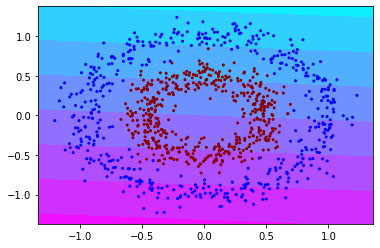

In [73]:
plot_class_model(X_val, y_val, model.predict)

- Cosa succede introducendo non linearità? Utilizziamo la funzione ReLU nello strato nascosto

In [74]:
model = Sequential([
    Dense(6, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])

In [75]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [76]:
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 1s 734us/step - loss: 0.7598 - acc: 0.4830
Epoch 2/10
1000/1000 [==============================] - 0s 243us/step - loss: 0.7244 - acc: 0.4070
Epoch 3/10
1000/1000 [==============================] - 0s 200us/step - loss: 0.7039 - acc: 0.4450
Epoch 4/10
1000/1000 [==============================] - 0s 205us/step - loss: 0.6878 - acc: 0.4530
Epoch 5/10
1000/1000 [==============================] - 0s 203us/step - loss: 0.6734 - acc: 0.4870
Epoch 6/10
1000/1000 [==============================] - 0s 252us/step - loss: 0.6595 - acc: 0.5300
Epoch 7/10
1000/1000 [==============================] - 0s 188us/step - loss: 0.6454 - acc: 0.5710
Epoch 8/10
1000/1000 [==============================] - 0s 218us/step - loss: 0.6304 - acc: 0.6070
Epoch 9/10
1000/1000 [==============================] - 0s 225us/step - loss: 0.6133 - acc: 0.7060
Epoch 10/10
1000/1000 [==============================] - 0s 221us/step - loss: 0.5932 - acc: 0.7710


- Si può notare che questa volta l'addestramento ha dato risultati

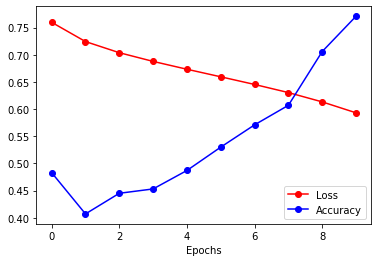

In [77]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["acc"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epochs");

In [78]:
model.evaluate(X_val, yt_val)

1000/1000 [==============================] - 0s 156us/step


[0.5843190402984619, 0.796]

- Il modello è ora più accurato

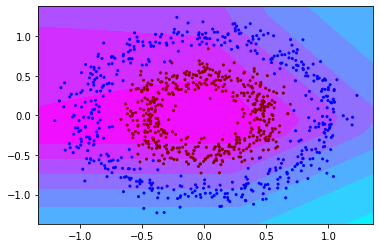

In [79]:
plot_class_model(X_val, y_val, model.predict)

- Possiamo aumentare l'espressività e quindi l'accuratezza del modello aumentando i nodi

In [64]:
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])

In [65]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [66]:
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 1s 594us/step - loss: 0.6713 - acc: 0.4980
Epoch 2/10
1000/1000 [==============================] - 0s 153us/step - loss: 0.6231 - acc: 0.6150
Epoch 3/10
1000/1000 [==============================] - 0s 175us/step - loss: 0.5778 - acc: 0.8370
Epoch 4/10
1000/1000 [==============================] - 0s 171us/step - loss: 0.5318 - acc: 0.9160
Epoch 5/10
1000/1000 [==============================] - 0s 154us/step - loss: 0.4846 - acc: 0.9510
Epoch 6/10
1000/1000 [==============================] - 0s 174us/step - loss: 0.4363 - acc: 0.9740
Epoch 7/10
1000/1000 [==============================] - 0s 155us/step - loss: 0.3900 - acc: 0.9800
Epoch 8/10
1000/1000 [==============================] - 0s 196us/step - loss: 0.3456 - acc: 0.9820
Epoch 9/10
1000/1000 [==============================] - 0s 172us/step - loss: 0.3057 - acc: 0.9840
Epoch 10/10
1000/1000 [==============================] - 0s 188us/step - loss: 0.2710 - acc: 0.9840


- Si noti quanto l'accuratezza sul training set raggiunge rapidamente livelli più alti

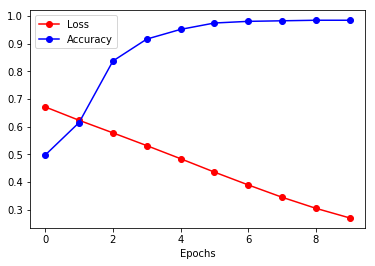

In [67]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["acc"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epochs");

In [68]:
model.evaluate(X_val, yt_val)

1000/1000 [==============================] - 0s 120us/step


[0.2536977386474609, 0.989]

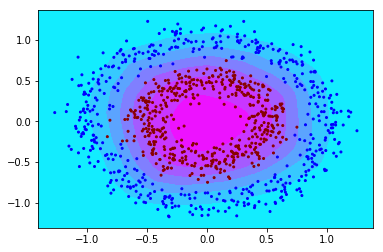

In [69]:
plot_class_model(X_val, y_val, model.predict)

- Abbiamo così ottenuto un classificatore accurato **senza definire manualmente nuove variabili**, ma lasciando che sia lo strato nascosto della rete ad apprendere una rappresentazione adeguata dei dati!

## Caso di Studio 1: Predizione Vendite

- I negozi sono interessati a prevedere quanto più accuratamente possibile le vendite giornaliere
  - per ottimizzare le scorte di magazzino, il personale da impiegare, ecc.
- Le vendite sono influenzate da diversi fattori
  - giorno della settimana, festività, promozioni, ...
- In questo caso di studio analizziamo dati relativi a più di 1.000 negozi della catena europea Rossmann
- La predizione su questi dati è stata oggetto di una competizione su Kaggle: https://www.kaggle.com/c/rossmann-store-sales
  - i dati che forniamo sono versioni già parzialmente preprocessate di quelli originali su Kaggle

## Dataset

- I dati sono forniti divisi in due file, per addestramento e validazione

In [82]:
#download("rossmann_train.csv.gz", "")
#download("rossmann_valid.csv.gz", "")

- Carichiamo i due file e vediamone la quantità di osservazioni

In [80]:
data_train = pd.read_csv("rossmann_train.csv.gz", parse_dates=["Date"], compression="gzip")

In [81]:
data_valid = pd.read_csv("rossmann_valid.csv.gz", parse_dates=["Date"], compression="gzip")

In [83]:
len(data_train), len(data_valid)

(804056, 40282)

In [84]:
data_train.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,314,2015-06-19,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,164.0,22.50,0,562,5032
1,458,2015-06-19,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,688,7362
2,961,2015-06-19,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,768,7764
3,132,2015-06-19,1,0,0,4,3,1040.0,0.0,0.0,1,27.0,2012.0,24186.0,35.50,0,692,7964


In [85]:
data_valid.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,1,2015-07-31,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75,0,555,5263
1,747,2015-07-31,1,0,1,3,3,45740.0,8.0,2008.0,0,0.0,0.0,83.0,24187.75,0,826,10708
2,772,2015-07-31,1,0,1,4,3,1850.0,0.0,0.0,0,0.0,0.0,24187.0,24187.75,0,635,5224
3,752,2015-07-31,1,0,1,1,1,970.0,3.0,2013.0,1,31.0,2013.0,28.0,24.00,0,565,7763


## Descrizione variabili

- Ogni riga è un'osservazione relativa ad un singolo negozio in una certa data, indicati dalle colonne `Store` e `Date`
- Le ultime due colonne `Customers` and `Sales` indicano rispettivamente il numero di clienti e il ricavo totale delle vendite per quel giorno in quel negozio
- Le altre colonne riportano informazioni note a priori relative a negozio e giorno
  - applicazione di promozioni
  - festività
  - tipologia di negozio
  - distanza da negozi concorrenti
- L'obiettivo è prevedere da queste informazioni il ricavo totale (`Sales`)

- Il ricavo totale `Sales` è ovviamente strettamente proporzionale al numero di clienti `Customers`
  - selezioniamo con `sample(N)` un numero limitato di campioni casuali per creare il grafico con più efficienza

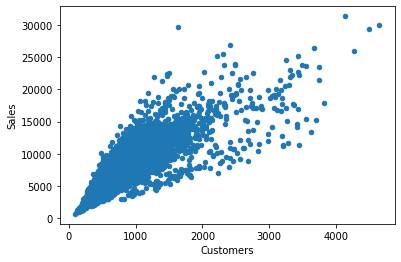

In [86]:
data_train.sample(10000).plot.scatter("Customers", "Sales")

- Non possiamo però usare la variabile `Customers` per la predizione, in quanto informazione non nota ad inizio giornata

- Dai dati vogliamo quindi rimuovere la colonna `Customers` (oltre a `Sales`) per avere le effettive variabili predittive
- D'altra parte, possiamo aggiungere feature potenzialmente utili scomponendo la data (`Date`) nei suoi componenti (giorno, mese, giorno della settimana, ...)
- Definiamo una funzione `process_rossmann` che applica le dovute trasformazioni ai dati passati e ricava le variabili predittive X e gli output attesi y

In [87]:
def process_rossmann(data):
    # crea una copia del DataFrame eliminando alcune colonne
    X = data.drop(["Date", "Customers", "Sales"], axis=1).copy()
    # aggiungi colonne derivate dalla data
    X["Day"] = data["Date"].dt.day
    X["Month"] = data["Date"].dt.month
    X["WeekOfYear"] = data["Date"].dt.weekofyear
    # estrai colonna da predire (Sales)
    y = data["Sales"]
    return X, y

- Applichiamo tale funzione sui due set di dati

In [88]:
X_train, y_train = process_rossmann(data_train)
X_val, y_val = process_rossmann(data_valid)

- Eseguiamo come prima la standardizzazione delle variabili

In [89]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train[:, None]).ravel()
y_val = scaler_y.transform(y_val[:, None]).ravel()

- Testiamo come baseline un modello di regressione lineare

In [90]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train);

- Con `score` calcoliamo l'accuratezza calcolata col coefficiente R²

In [91]:
model.score(X_val, y_val)

0.20375602665270454

- Nella competizione Kaggle viene usata come misura di riferimento il _Root Mean Squared Percentage Error_ (RMSPE)
- Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni, avendo cura di riportare i valori standardizzati nella scala originale

In [94]:
def rmspe(y_real, y_pred):
    y_real = scaler_y.inverse_transform(y_real)
    y_pred = scaler_y.inverse_transform(y_pred)
    return np.sqrt(np.mean((y_pred/y_real-1) ** 2))

- Il modello di regressione lineare ottiene un RMSPE pari a...

In [96]:
rmspe(y_val, model.predict(X_val))

0.516754725892877

- Possiamo ottenere RMSPE migliori (inferiori) con modelli più complessi, ad es. con variabili di secondo grado e regolarizzazione...

In [97]:
from sklearn.linear_model import Ridge
model = Pipeline([
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Ridge(alpha=0.01))
])
model.fit(X_train, y_train)
rmspe(y_val, model.predict(X_val))

0.4669650779318057

- Vediamo i risultati ottenibili con reti neurali
- Iniziamo da una rete con un singolo strato nascosto con attivazione ReLU
- Per la dimensione dell'input leggiamo direttamente il numero di colonne di X

In [98]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [99]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 19s 23us/step - loss: 0.7297
Epoch 2/5
804056/804056 [==============================] - 17s 21us/step - loss: 0.6302
Epoch 3/5
804056/804056 [==============================] - 16s 20us/step - loss: 0.5723
Epoch 4/5
804056/804056 [==============================] - 16s 20us/step - loss: 0.5380
Epoch 5/5
804056/804056 [==============================] - 16s 20us/step - loss: 0.5137


- Dati dei valori in input, con `predict` otteniamo i valori predetti (normalizzati)

In [100]:
model.predict(X_val[:5])

array([[0.30510306],
       [1.6205136 ],
       [0.44883412],
       [0.14193928],
       [1.0326706 ]], dtype=float32)

- Calcoliamo l'RMSPE dalle predizioni come visto sopra

In [214]:
rmspe(y_val, model.predict(X_val).ravel())

0.4455253080056343

- Testiamo ora una rete con 3 strati nascosti con diversi numeri di nodi
  - ogni strato idealmente corrisponde ad una rappresentazione diversa dell'input

In [216]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [217]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 41s 50us/step - loss: 8215044.6104
Epoch 2/5
  4000/804056 [..............................] - ETA: 2:22 - loss: 7170769.7875

/home/rrobby/software/miniconda3/envs/dltutorial/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122671). Check your callbacks.
  % delta_t_median)


804056/804056 [==============================] - 29s 37us/step - loss: 7227164.9599
Epoch 3/5
804056/804056 [==============================] - 32s 40us/step - loss: 6459173.9449
Epoch 4/5
804056/804056 [==============================] - 33s 41us/step - loss: 5459950.7382
Epoch 5/5
804056/804056 [==============================] - 31s 38us/step - loss: 4790268.3135


In [218]:
rmspe(y_val, model.predict(X_val).ravel())

0.34077464568102056

- Siamo così riusciti a migliorare il RMSPE rispetto ai modelli di regressione semplici
  - I risultati sono ulteriormente migliorabili aumentando le epoche di addestramento

## Regolarizzazione

- Nelle reti neurali si possono introdurre diversi accorgimenti per evitare l'overfitting
- Come in altri modelli, possiamo utilizzare la regolarizzazione per evitare che i parametri del modello assumano valori elevati
- I tipi di regolarizzazione applicabili sono `l2` (ridge), `l1` (lasso) o entrambe (elastic net)
- La regolarizzazione può essere applicata sui pesi (_kernel_), sui bias e/o sull'output della funzione di attivazione (_activity_)
- Nell'esempio seguente riprendiamo la rete con un singolo strato nascosto applicando la regolarizzazione L2 ai pesi

In [113]:
from keras.regularizers import l2
model = Sequential([
    Dense(512, activation="relu", kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
    Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [114]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 45s 56us/step - loss: 0.7654
Epoch 2/5
804056/804056 [==============================] - 41s 52us/step - loss: 0.6134
Epoch 3/5
804056/804056 [==============================] - 40s 50us/step - loss: 0.5707
Epoch 4/5
804056/804056 [==============================] - 38s 47us/step - loss: 0.5436
Epoch 5/5
804056/804056 [==============================] - 37s 46us/step - loss: 0.5263


In [115]:
rmspe(y_val, model.predict(X_val).ravel())

0.3599408290813827

## Dropout

- Il _dropout_, applicato nell'addestramento della rete, azzera ad ogni batch alcuni input casuali in uno strato
  - in fase di predizione (inferenza) non cambia nulla
- In questo modo la rete si addestra su informazioni incomplete, con possibile riduzione dell'overfitting
- Per applicarlo introduciamo nella rete uno strato `Dropout`, in cui specifichiamo la frazione di input da azzerare (ad es 10\%)
  - lo strato dropout è "astratto", non introduce nuovi nodi o nuovi parametri da addestrare

In [116]:
from keras.layers import Dropout
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dropout(0.1),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [117]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 49s 61us/step - loss: 0.5337
Epoch 2/5
804056/804056 [==============================] - 46s 57us/step - loss: 0.3112
Epoch 3/5
804056/804056 [==============================] - 41s 51us/step - loss: 0.2632
Epoch 4/5
804056/804056 [==============================] - 42s 52us/step - loss: 0.2443
Epoch 5/5
804056/804056 [==============================] - 39s 49us/step - loss: 0.2315


In [118]:
rmspe(y_val, model.predict(X_val).ravel())

0.22505579772130543

## Caso di Studio 2: Riconoscimento Attività Umane

- Gli smartphone moderni contengono diversi sensori di movimento, quali accelerometro e oscilloscopio
- È possibile raccogliendo dati da questi sensori risconoscere quale attività stia svolgendo una persona?
  - È in piedi fermo? Sta camminando? È seduto? ...
- Vediamo come addestrare una rete neurale a riconoscere l'attività svolta da una sequenza di letture dei sensori
- Tale rete può essere in seguito integrata in un'app per smartphone, ad es. per il tracking di attività fisica

## Dataset

- Utilizziamo un set di dati di letture da sensori diponibile online su https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
- Sono distinte 6 classi relative a diverse attività o posizioni...
  - camminare, salire scale, scendere scale, seduti, in piedi, sdraiati
- ...svolte da 30 persone mentre indossavano uno smartphone
- 50 volte al secondo sono stati campionati 9 valori
  - 3 sensori (accelerazione con e senza gravità, rotazione) per 3 assi (XYZ)
- Il dataset finale ha 10.299 finestre temporali (tra training e test) di 128 istanti, a ciascuna è associata una delle 6 classi

- Scarichiamo il dataset in formato ZIP dal Web...

In [119]:
download("HARDataset.zip", "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip")

- ...ed estraiamo i file

In [120]:
from zipfile import ZipFile
if not os.path.isdir("UCI HAR Dataset"):
    with ZipFile("HARDataset.zip") as zipf:
        zipf.extractall()

- I dati sono già divisi in due set `train` e `test`
- Nella directory `Inertial Signals` di ciascuno si trovano i file con i dati grezzi ottenuti dai sensori
- Sono considerati 3 diversi sensori:
  - `total_acc`: accelerazione (accelerometro)
  - `body_acc`: accelerazione senza la forza di gravità
  - `body_gyro`: rotazione (giroscopio)
- Per ogni sensore si considerano tre assi x, y, z come da figura:

![x da sinistra verso destra, y dal basso verso l'alto, z da dietro verso davanti](https://developer.android.com/images/axis_device.png)

- La seguente funzione carica tutti i dati descritti sopra dai file estratti

In [121]:
def load_dataset(prefix, sensors):
    def load_file(filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values
    def load_dataset_group(group, prefix, sensors):
        filepath = prefix + group + "/Inertial Signals/"
        filenames = ["{}_{}_{}.txt".format(sensor, axis, group)
                     for sensor in sensors for axis in "xyz"]
        X_data = [load_file(filepath + name) for name in filenames]
        X = np.dstack(X_data)
        y = load_file(prefix + group + '/y_'+group+'.txt').ravel() - 1
        return X, y
    trainX, trainy = load_dataset_group('train', prefix, sensors)
    testX, testy = load_dataset_group('test', prefix, sensors)
    return trainX, trainy, testX, testy

- Invochiamo la funzione, specificando i sensori per cui vogliamo caricare i dati
  - si può eventualmente usare solo una parte dei sensori, ad es. per smartphone dotati solo di alcuni di essi

In [122]:
X_train, y_train, X_test, y_test = load_dataset(
    "UCI HAR Dataset/",
    ["total_acc", "body_acc", "body_gyro"]
)

- Otteniamo due dataset "train" e "test", ciascuno costituito da
  - un array 3D X con N osservazioni (asse 0) di 128 campioni (asse 1) consecutivi dei 9 valori (asse 2)
  - un array 1D y con le etichette delle N osservazioni

In [123]:
X_train.shape, y_train.shape

((7352, 128, 9), (7352,))

In [124]:
X_test.shape, y_test.shape

((2947, 128, 9), (2947,))

- Carichiamo dal file `activity_labels.txt` i nomi delle attività riconosciute

In [126]:
with open("UCI HAR Dataset/activity_labels.txt", "rt") as f:
    labels = [line.split(" ")[1].strip() for line in f]

In [127]:
labels

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

- Possiamo usarle per vedere la distribuzione di osservazioni delle diverse attività in training e test set

In [128]:
pd.Series(labels)[y_train].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
dtype: int64

In [129]:
pd.Series(labels)[y_test].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
dtype: int64

- Codifichiamo le etichette (y) in vettori one-hot da usare come output atteso della rete

In [133]:
yt_train = to_categorical(y_train)
yt_test = to_categorical(y_test)

- I valori in ingresso hanno già media vicina a 0 e dev. standard vicina a 1, non è necessario standardizzarli

In [134]:
X_train.mean(), X_train.std()

(0.1020660572380442, 0.4021651763827928)

- Dalle dimensioni degli array ricaviamo il numero di campioni per osservazione (128), di valori per campione (9) e di possibili classi (6)

In [141]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], yt_train.shape[1]

- Costruiamo una prima rete per la classificazione con un singolo strato nascosto
- In input usiamo uno strato `Flatten` per convertire la matrice 128x9 con cui è rappresentata ciascuna osservazione in un vettore di 1.152 elementi
  - questo strato cambia solo la rappresentazione dei dati, non introduce nodi o parametri
  - con `input_shape` indichiamo la dimensione attesa della matrice
- In output usiamo come visto prima uno strato con attivazione softmax con un nodo per classe, in questo caso 6

In [142]:
from keras.layers import Flatten
model = Sequential([
    Flatten(input_shape=(n_timesteps, n_features)),
    Dense(32, activation="relu"),
    Dense(n_outputs, activation="softmax")
])

In [143]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [144]:
model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
7352/7352 [==============================] - 2s 301us/step - loss: 0.7311 - acc: 0.7342
Epoch 2/10
7352/7352 [==============================] - 1s 189us/step - loss: 0.3317 - acc: 0.8885
Epoch 3/10
7352/7352 [==============================] - 1s 181us/step - loss: 0.2270 - acc: 0.9184
Epoch 4/10
7352/7352 [==============================] - 1s 179us/step - loss: 0.1756 - acc: 0.9348
Epoch 5/10
7352/7352 [==============================] - 1s 183us/step - loss: 0.1484 - acc: 0.9437
Epoch 6/10
7352/7352 [==============================] - 1s 181us/step - loss: 0.1321 - acc: 0.9499
Epoch 7/10
7352/7352 [==============================] - 1s 195us/step - loss: 0.1220 - acc: 0.9513
Epoch 8/10
7352/7352 [==============================] - 1s 179us/step - loss: 0.1141 - acc: 0.9533
Epoch 9/10
7352/7352 [==============================] - 1s 195us/step - loss: 0.1091 - acc: 0.9544
Epoch 10/10
7352/7352 [==============================] - 1s 176us/step - loss: 0.1050 - acc: 0.9546


In [153]:
model.evaluate(X_test, yt_test)

2947/2947 [==============================] - 0s 111us/step


[0.5460815663333486, 0.8771632168306752]

- Possiamo aggiungere uno strato nascosto per rendere più accurata la rete

In [154]:
from keras.layers import Flatten
model = Sequential([
    Flatten(input_shape=(n_timesteps, n_features)),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(n_outputs, activation="softmax")
])

In [155]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [156]:
model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
7352/7352 [==============================] - 2s 296us/step - loss: 0.4862 - acc: 0.8248
Epoch 2/10
7352/7352 [==============================] - 1s 192us/step - loss: 0.1708 - acc: 0.9357
Epoch 3/10
7352/7352 [==============================] - 1s 196us/step - loss: 0.1266 - acc: 0.9475
Epoch 4/10
7352/7352 [==============================] - 2s 206us/step - loss: 0.1069 - acc: 0.9543
Epoch 5/10
7352/7352 [==============================] - 2s 222us/step - loss: 0.1018 - acc: 0.9554
Epoch 6/10
7352/7352 [==============================] - 1s 200us/step - loss: 0.0960 - acc: 0.9585
Epoch 7/10
7352/7352 [==============================] - 1s 199us/step - loss: 0.0892 - acc: 0.9593
Epoch 8/10
7352/7352 [==============================] - 1s 204us/step - loss: 0.0824 - acc: 0.9625
Epoch 9/10
7352/7352 [==============================] - 2s 209us/step - loss: 0.1418 - acc: 0.9468
Epoch 10/10
7352/7352 [==============================] - 2s 211us/step - loss: 0.1134 - acc: 0.9550


In [157]:
model.evaluate(X_test, yt_test)

2947/2947 [==============================] - 0s 116us/step


[0.5896802162915888, 0.8832711231761113]

## Reti convoluzionali

In [158]:
from keras.layers import Conv1D
model = Sequential([
    Conv1D(16, 15, input_shape=(n_timesteps, n_features)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(n_outputs, activation="softmax")
])

In [159]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [160]:
model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
7352/7352 [==============================] - 3s 355us/step - loss: 0.5083 - acc: 0.8186
Epoch 2/10
7352/7352 [==============================] - 2s 237us/step - loss: 0.1978 - acc: 0.9241
Epoch 3/10
7352/7352 [==============================] - 2s 231us/step - loss: 0.1490 - acc: 0.9392
Epoch 4/10
7352/7352 [==============================] - 2s 232us/step - loss: 0.1260 - acc: 0.9486
Epoch 5/10
7352/7352 [==============================] - 2s 237us/step - loss: 0.1143 - acc: 0.9504
Epoch 6/10
7352/7352 [==============================] - 2s 231us/step - loss: 0.1206 - acc: 0.9498
Epoch 7/10
7352/7352 [==============================] - 2s 278us/step - loss: 0.1328 - acc: 0.9459
Epoch 8/10
7352/7352 [==============================] - 2s 252us/step - loss: 0.1197 - acc: 0.9528
Epoch 9/10
7352/7352 [==============================] - 2s 242us/step - loss: 0.1154 - acc: 0.9529
Epoch 10/10
7352/7352 [==============================] - 2s 292us/step - loss: 0.1129 - acc: 0.9532


In [161]:
model.evaluate(X_test, yt_test)

2947/2947 [==============================] - 0s 152us/step


[0.6078760558382534, 0.8890397013912453]